In [6]:
import torch
from torchvision.models import DenseNet121_Weights
from torchvision.models import densenet121
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import random_split
from CustomDataset import CustomDataset
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm.auto import tqdm

In [7]:
#Device Agnostic Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomInvert(),
    transforms.ToTensor()
])

In [10]:

root_dir = r'Dataset\Image\images_001'
csv_file = r'Dataset\Data_entry_2017.csv'

dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir,transform=transform)

#Splittig Data
train_size = int(0.8 * len(CustomDataset))
test_size = len(CustomDataset) - train_size
train_dataset, test_dataset = random_split(CustomDataset, [train_size, test_size])


# Create datasets and loaders


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



KeyError: 'Image Index'

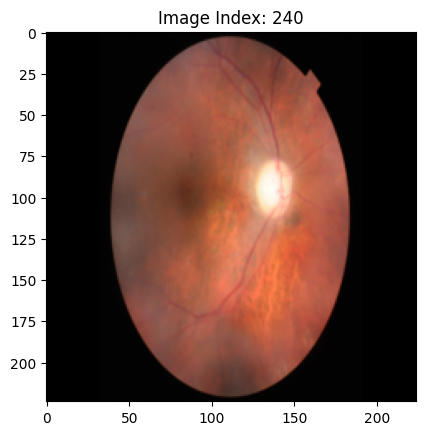

Labels for Image Index 240 with value 1:
MH: 1.0
TSLN: 1.0
ODC: 1.0


In [ ]:


# Define the label columns
label_columns = train_dataset.classes

# Get a random index from the training dataset
random_index = random.randint(0, len(train_dataset) - 1)

# Retrieve the image and labels for the random index
sample_image, sample_labels = train_dataset[random_index]

sample_image = sample_image.permute(1,2,0)
# print(sample_labels)
# Display the image
plt.imshow(sample_image)
plt.title(f"Image Index: {random_index + 1}")
plt.show()

# Print labels with value 1
print(f"Labels for Image Index {random_index + 1} with value 1:")
for column, value in zip(label_columns, sample_labels):
    if value == 1:
        print(f"{column}: {value}")

In [ ]:
#Hyper Parmaeters
lr = 0.01
epochs = 5



In [ ]:
model = densenet121(weights = DenseNet121_Weights.DEFAULT)
# model = densenet121(pretrained = True)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Loss_fn and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [ ]:
# Training Loop 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}/{epochs}")
    loss_values = []
    
    for batch_idx,(img,label) in enumerate(tqdm(train_loader)):
        pred = model(Image)
        
        loss = loss_fn(pred,label)
        loss_values.append()
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
    print(f"Loss: {loss.item()}")
    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0/5


  0%|          | 0/60 [00:00<?, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (module, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!module!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!module!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:
#Accuracy fn

def accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device = device)
            y = y.to(device = device)
            
            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        
    model.train()
